# Imports

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import holidays
from datetime import date
from datetime import datetime
from meteostat import Point, Daily
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize,StandardScaler

import xgboost
import pickle

# Reading Dataset

In [11]:
df = pd.read_csv(os.path.join(os.os.getcwd(),"data/DPS_xgb_reg.pkl"))

In [12]:
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


# Data Filteration


In [13]:
### Select only first five columns
df = df.iloc[:,0:5]

In [14]:
### Rename columns
df = df.rename(columns={"MONATSZAHL":"category","AUSPRAEGUNG":"accident_type","JAHR":"year","MONAT":"month","WERT":"value"})

In [15]:
### Drop non values after 2021
df = df[df["value"].notnull()]

In [16]:
df["month"] = pd.to_datetime(df['month'], format="%Y%m").dt.month

In [17]:
df.head()

,category,accident_type,year,month,value
24,Alkoholunfälle,insgesamt,2021,1,16.0
25,Alkoholunfälle,insgesamt,2021,2,14.0
26,Alkoholunfälle,insgesamt,2021,3,24.0
27,Alkoholunfälle,insgesamt,2021,4,16.0
28,Alkoholunfälle,insgesamt,2021,5,24.0


# Feature Engineering

Let's extract the number of holidays in that month in each specific year, we will use the holiday package to determine holidays

In [18]:
year_values = df["year"].unique()

In [19]:
holidays_dict = { str(year):{str(i):[] for i in range(1,13)} for year in year_values}
for year in list(year_values):
  for date, name in sorted(holidays.DE(years=int(year)).items()):
    holidays_dict[str(year)][str(date.month)].append(name)

In [20]:
holidays_dict

{'2021': {'1': ["New Year's Day"],
  '2': [],
  '3': [],
  '4': ['Good Friday', 'Easter Monday'],
  '5': ['Labor Day', 'Ascension Day', 'Whit Monday'],
  '6': [],
  '7': [],
  '8': [],
  '9': [],
  '10': ['German Unity Day'],
  '11': [],
  '12': ['Christmas Day', 'Second Day of Christmas']},
 '2020': {'1': ["New Year's Day"],
  '2': [],
  '3': [],
  '4': ['Good Friday', 'Easter Monday'],
  '5': ['Labor Day', 'Ascension Day'],
  '6': ['Whit Monday'],
  '7': [],
  '8': [],
  '9': [],
  '10': ['German Unity Day'],
  '11': [],
  '12': ['Christmas Day', 'Second Day of Christmas']},
 '2019': {'1': ["New Year's Day"],
  '2': [],
  '3': [],
  '4': ['Good Friday', 'Easter Monday'],
  '5': ['Labor Day', 'Ascension Day'],
  '6': ['Whit Monday'],
  '7': [],
  '8': [],
  '9': [],
  '10': ['German Unity Day'],
  '11': [],
  '12': ['Christmas Day', 'Second Day of Christmas']},
 '2018': {'1': ["New Year's Day"],
  '2': [],
  '3': ['Good Friday'],
  '4': ['Easter Monday'],
  '5': ['Labor Day', 'Ascensi

In [21]:
### Adding number of hoildays to the data
number_of_holidays = []
for idx,row in df.iterrows():
  number_of_holidays.append(len(holidays_dict[str(row["year"])][str(row["month"])]))
df["number_of_holidays"] = number_of_holidays

Let's extract the weather info. The weather data will be approximate. We will set the location Berlin.
https://meteostat.net/en/station/10382?t=2023-11-11/2023-11-18

In [22]:
berlin = Point(52.5667, 13.3167,37)
weather_data = []
for idx,row in tqdm(df.iterrows()):
  start = datetime(row["year"], row["month"],1)
  end = datetime(row["year"], row["month"],28)
  data = Daily(berlin, start, end)
  data = data.fetch()
  weather_data.append(data.mean().values)


1848it [02:06, 14.59it/s]


In [23]:
mean_weather_data = {"tavg":[],"tmin":[],"tmax":[],"prcp":[],"snow":[],"wdir":[],"wspd":[],"wpgt":[],"pres":[],"tsun":[]}

In [24]:
for x in weather_data:
  i =0
  for k,v in mean_weather_data.items():
    mean_weather_data[k].append(x[i])
    i =i+1

In [25]:
for k,v in mean_weather_data.items():
  df[k] = v

In [26]:
##getting the average value per month
average_value_per_month = df.groupby("month")["value"].agg(["mean"]).reset_index()

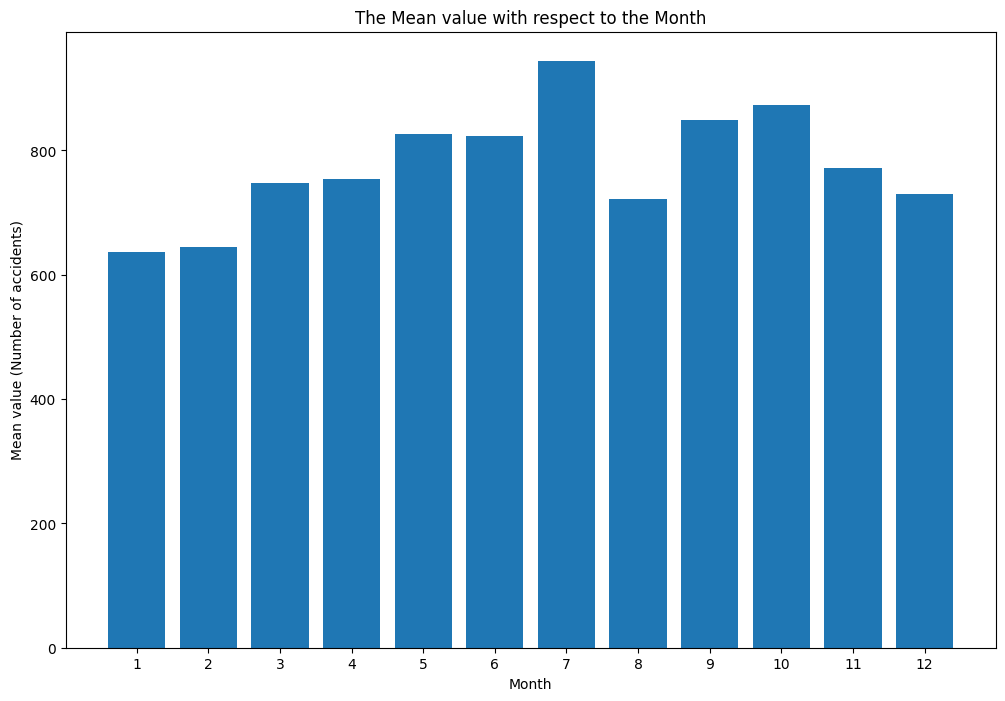

In [27]:
##plotting the average value per month
plt.figure(figsize=(12,8));
plt.bar(average_value_per_month['month'],average_value_per_month['mean']);
plt.title("The Mean value with respect to the Month");
plt.ylabel("Mean value (Number of accidents)");
plt.xlabel("Month");
plt.xticks(np.arange(1,13));

Notes:


1.   January has the least number of accidents
2.   July has the most number of accidents



# Data Exploration


In [ ]:
df.shape

(1848, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1848 entries, 24 to 2015
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       1848 non-null   object 
 1   accident_type  1848 non-null   object 
 2   year           1848 non-null   int64  
 3   month          1848 non-null   int64  
 4   value          1848 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 86.6+ KB


In [ ]:
df["category"].value_counts()

Verkehrsunfälle    792
Alkoholunfälle     528
Fluchtunfälle      528
Name: category, dtype: int64

**{"Verkehrsunfälle":"traffic_accidents",  
 "Alkoholunfälle":"alcohol_accidents",  
 "Fluchtunfälle":"escape_accidents"}**

In [ ]:
df["accident_type"].value_counts()

insgesamt                 792
Verletzte und Getötete    792
mit Personenschäden       264
Name: accident_type, dtype: int64

**{"insgesamt":"in_total",  
"Verletzte und Getötete":"Injured and killed",  
 "mit Personenschäden":"with personal injuries"}**

In [ ]:
df["value"].describe()

count    1848.000000
mean      776.984848
std      1176.030443
min         0.000000
25%        38.000000
50%       358.500000
75%       811.000000
max      4763.000000
Name: value, dtype: float64

In [ ]:
(df["value"]==0.0).sum()

1

In [ ]:
df["year"].value_counts()

2021    84
2020    84
2001    84
2002    84
2003    84
2004    84
2005    84
2006    84
2007    84
2008    84
2009    84
2010    84
2011    84
2012    84
2013    84
2014    84
2015    84
2016    84
2017    84
2018    84
2019    84
2000    84
Name: year, dtype: int64

In [ ]:
df["month"].value_counts()

1     154
2     154
3     154
4     154
5     154
6     154
7     154
8     154
9     154
10    154
11    154
12    154
Name: month, dtype: int64

In [ ]:
df[df["year"]==2005]["month"].value_counts()

1     7
2     7
3     7
4     7
5     7
6     7
7     7
8     7
9     7
10    7
11    7
12    7
Name: month, dtype: int64

Notes:  


1.   Our data is collected between year 2000 to 2021.
2.   We have a 7 samples for each month in each year.
3.   Our range of the number accidents is (0-4736) with a mean of 776 and median 358



## Univariate Exploration


<BarContainer object of 3 artists>

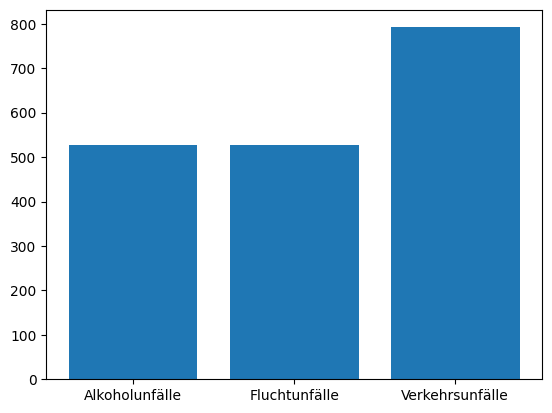

In [ ]:
unique_values, counts = np.unique(df["category"].values,return_counts=True)
plt.bar(x=unique_values,height=counts)

<BarContainer object of 3 artists>

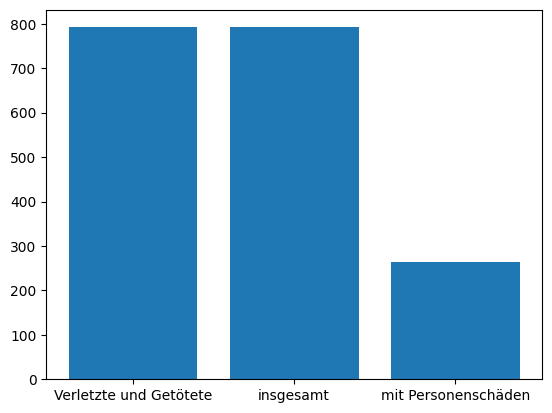

In [ ]:
unique_values, counts = np.unique(df["accident_type"].values,return_counts=True)
plt.bar(x=unique_values,height=counts)

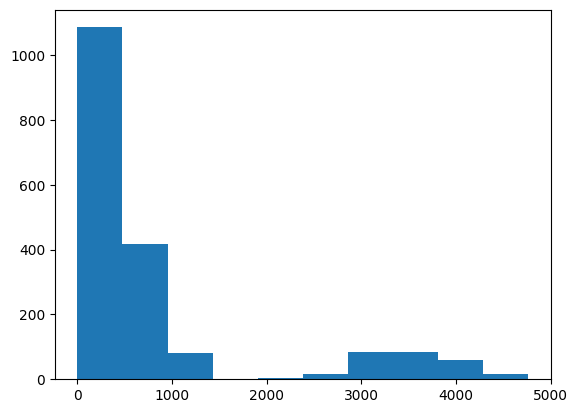

In [ ]:
plt.hist(df["value"].values);

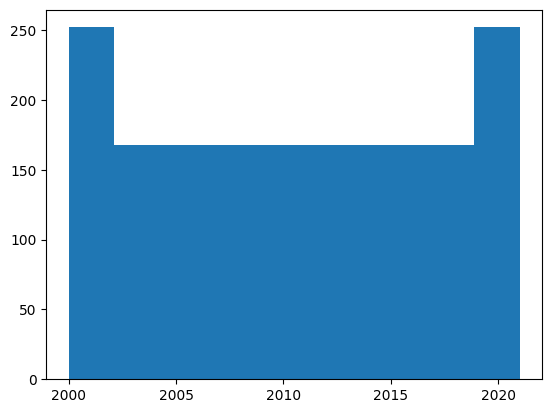

In [ ]:
plt.hist(df["year"].values);

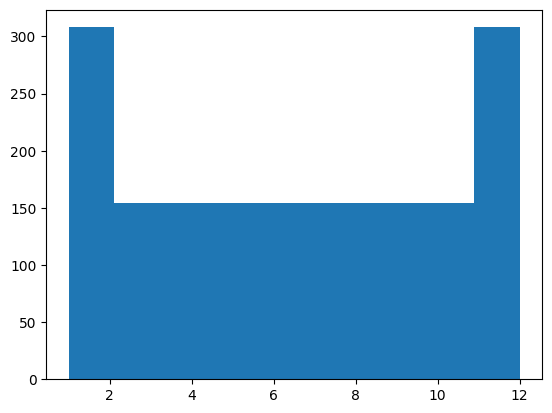

In [ ]:
plt.hist(df["month"].values);

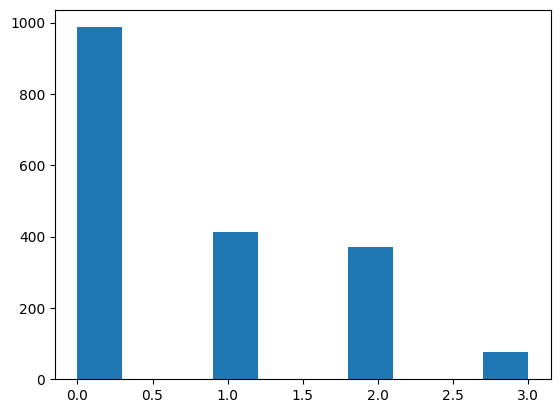

In [ ]:
plt.hist(df["number_of_holidays"].values);

## Bivariate Exploration

# Correlation

In [51]:
corrMatrix=df.corr()
corrMatrix

,year,month,value,number_of_holidays,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
year,1.000000e+00,-7.893220e-16,0.007348,0.005866,0.034453,0.013601,0.046659,-0.086164,-0.045803,-0.030454,0.025296,0.082217,0.006417,0.033627
month,-7.893220e-16,1.000000e+00,0.034278,-0.003594,0.240193,0.304043,0.197707,0.077569,-0.175962,-0.063208,-0.204986,-0.236779,-0.031922,-0.072785
value,7.348412e-03,3.427822e-02,1.000000,-0.008153,0.053669,0.053750,0.052913,0.009289,-0.028150,0.000212,-0.028215,-0.001745,-0.000102,0.037810
number_of_holidays,5.866387e-03,-3.593809e-03,-0.008153,1.000000,-0.180426,-0.211587,-0.168748,-0.113374,0.036438,-0.031296,0.138236,0.130570,-0.017464,-0.048890
tavg,3.445251e-02,2.401930e-01,0.053669,-0.180426,1.000000,0.989771,0.995924,0.252508,-0.376551,0.065233,-0.439881,0.095375,-0.082151,0.823376
tmin,1.360082e-02,3.040426e-01,0.053750,-0.211587,0.989771,1.000000,0.973955,0.304365,-0.381078,0.075326,-0.413394,0.081862,-0.123561,0.745702
tmax,4.665858e-02,1.977068e-01,0.052913,-0.168748,0.995924,0.973955,1.000000,0.221262,-0.371706,0.056838,-0.452077,0.102300,-0.057622,0.861111
prcp,-8.616378e-02,7.756865e-02,0.009289,-0.113374,0.252508,0.304365,0.221262,1.000000,-0.104968,0.224574,0.065719,0.223743,-0.381625,0.005692
snow,-4.580253e-02,-1.759618e-01,-0.028150,0.036438,-0.376551,-0.381078,-0.371706,-0.104968,1.000000,-0.174449,-0.004706,-0.192292,-0.082901,-0.248570
wdir,-3.045409e-02,-6.320817e-02,0.000212,-0.031296,0.065233,0.075326,0.056838,0.224574,-0.174449,1.000000,0.369277,0.441815,-0.081768,-0.099638


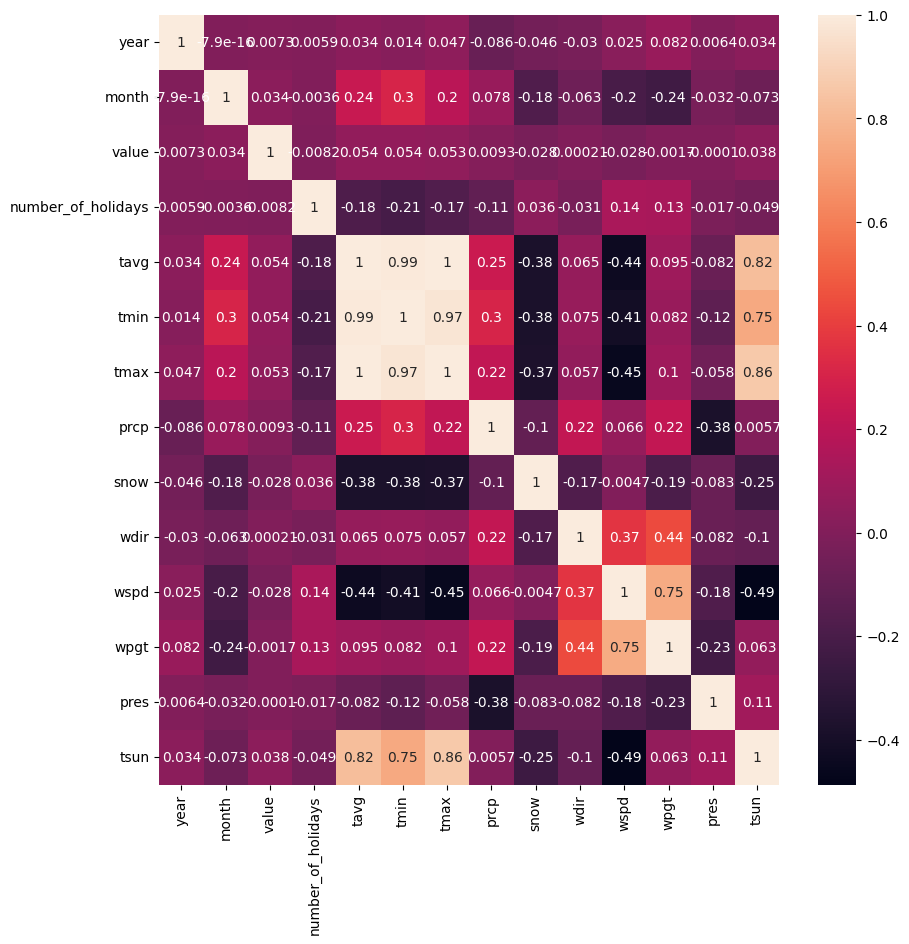

In [52]:
corrMatrix=df.corr()
plt.figure(figsize=(10,10));
sn.heatmap(corrMatrix,annot=True);

Notes:


1.   There are low correlation among features
2.   There are also low correlation between label "value" and the other features.
3.   "month" is the most correlated feature with the label "value"
4.   We can notice the negative correlation between the number of holidays and the label "value"



# Feature Selection

In [53]:
corr_with_label = 0.0005  #correlation threshold for target
corr_between_features = 0.75 #correlation threshold between features
# drop less correlated ones with target
corr_target = abs(corrMatrix['value'])

In [54]:
relevant_features = corr_target[corr_target > corr_with_label]
df_selected = df[list(relevant_features.index)]
print('Selected Columns after filtering correlation with target', df_selected.columns)

Selected Columns after filtering correlation with target Index(['year', 'month', 'value', 'number_of_holidays', 'tavg', 'tmin', 'tmax',
       'prcp', 'snow', 'wspd', 'wpgt', 'tsun'],
      dtype='object')


In [55]:
df_selected_label = df_selected["value"].values

In [56]:
cor = df_selected.corr().abs()

In [57]:
# drop highly correlated features
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_between_features)]
df_selected = df_selected.drop(df_selected[to_drop], axis=1)
df_selected = df_selected[[cols for cols in df_selected.columns if cols != 'value']]
print('Selected Columns after filtering  high correlation between features', df_selected.columns)

Selected Columns after filtering  high correlation between features Index(['year', 'month', 'number_of_holidays', 'tavg', 'prcp', 'snow', 'wspd'], dtype='object')


Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


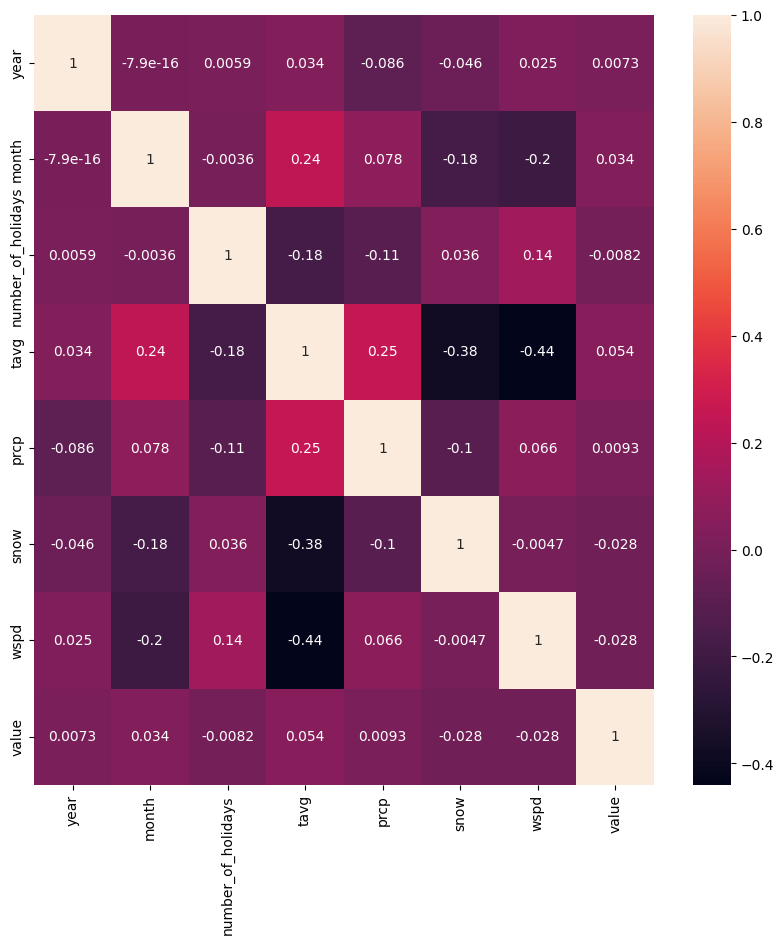

In [58]:
df_selected["value"] = df_selected_label
corrMatrix=df_selected.corr()
plt.figure(figsize=(10,10));
sn.heatmap(corrMatrix,annot=True);

# Model

**Let's take years (2018-2019-2020-2021) as our validation set**

In [79]:
df = df[(df['category'] == 'Alkoholunfälle') & (df['accident_type'] == 'insgesamt')]

In [80]:
df_valid = df[df["year"]>=2018]
df_train = df[df["year"]<2018]

In [81]:
df_train_x = df_train.drop(columns=["category","accident_type","value"])
# df_train_x = df_train.drop(columns=["value"])
df_train_y = df_train["value"]

In [82]:
df_valid_x = df_valid.drop(columns=["category","accident_type","value"])
# df_valid_x = df_valid.drop(columns=["value"])
df_valid_y = df_valid["value"]

In [83]:
scaler = StandardScaler().fit(df_train_x)
df_train_x_transformed = scaler.transform(df_train_x)
df_valid_x_transformed = scaler.transform(df_valid_x)

## Adaboost

In [84]:
clf = AdaBoostRegressor(n_estimators=150,random_state=42,learning_rate=0.9,loss="exponential")
clf = clf.fit(df_train_x_transformed,df_train_y)

In [85]:
predicted_valid = clf.predict(df_valid_x_transformed)
predicted_train = clf.predict(df_train_x_transformed)

In [86]:
mean_squared_error(df_train_y, predicted_train)

46.25321471028907

In [87]:
mean_squared_error(df_valid_y, predicted_valid)

59.09535557357083

##XGBoost

In [387]:
xgbmodel = xgboost.XGBRegressor(n_estimators=15, max_depth=2, eta=0.09, subsample=0.6, colsample_bytree=0.9,learning_rate=0.3,alpha=0.7)
xgbmodel = xgbmodel.fit(df_train_x_transformed,df_train_y)

In [388]:
predicted_valid = xgbmodel.predict(df_valid_x_transformed)
predicted_train = xgbmodel.predict(df_train_x_transformed)

In [389]:
mean_squared_error(df_train_y, predicted_train)

49.73122393656555

In [390]:
mean_squared_error(df_valid_y, predicted_valid)

52.83417929310607

# Model Saving

In [396]:

file_name = os.path.join(os.os.getcwd(),"model/DPS_xgb_reg.pkl")
pickle.dump(xgbmodel, open(file_name, "wb"))

file_name = os.path.join(os.os.getcwd(),"model/DPS_adaboost_reg.pkl")
pickle.dump(clf, open(file_name, "wb"))


# Draw predicted vs actual

In [391]:
df_valid_sample = df_valid[(df_valid["year"]==2018)|(df_valid["year"]==2019)]

In [392]:
df_valid_sample_x = df_valid_sample.drop(columns=["category","accident_type","value"])

df_valid_sample_y =  df_valid_sample["value"]

df_valid_sample_x_transformed = scaler.transform(df_valid_sample_x)

In [393]:
df_valid_sample["time"] = df_valid_sample["year"].astype(str) +"_"+ df_valid_sample["month"].astype(str)

df_valid_sample = df_valid_sample.sort_values(by="time")

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


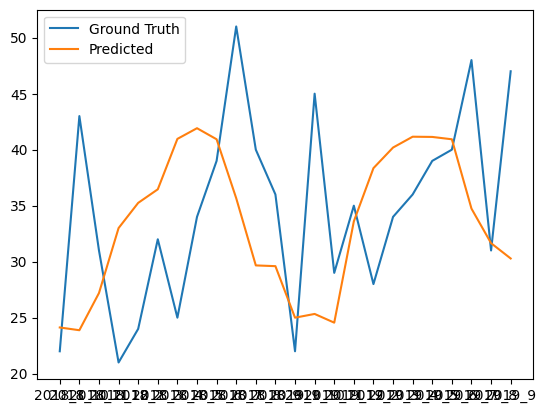

In [394]:
plt.plot(df_valid_sample["time"],df_valid_sample["value"],label='Ground Truth')
plt.plot(df_valid_sample["time"],xgbmodel.predict(df_valid_sample_x_transformed),label='Predicted')
plt.legend()